## **Thai-digit handwritten classification with Pytorch**

Repository: https://github.com/kittinan/thai-handwriting-number

## **Download and clean the dataset from the repository**

- Download the data from https://github.com/kittinan/thai-handwriting-number by cloning the repository
- Remove files that have character mismatch (as suggested by the the creator)

In [ ]:
!git clone https://github.com/kittinan/thai-handwriting-number

In [1]:
import os
import os.path as op
from glob import glob
from pathlib import Path

directory = "thai-handwritten-number/data/raw/thai-handwriting-number.appspot.com/"
remove_paths = [
    '7c9108fe-b240-4632-a024-f1ee922962ec',
    '20_a2178975-acff-4afe-88b9-f6fee8694ceb',
    'de366cab-6532-42ed-9926-38351927019b',
    '76c2e443-c8d1-40b0-96a9-073548c9617b',
    '21_e95ad3b8-30cb-47ad-9f68-2a5bb7aeb5bb',
    'e95ad3b8-30cb-47ad-9f68-2a5bb7aeb5bb',
    'fb05cb2a-c27b-4476-8cff-74f5ddbc8224',
    '078c1b18-e672-466d-a30b-f49a81710be6',
    '67ce79dc-de9c-4956-ad7b-fabf7aa9c6fa',
    '729207eb-f3f7-46e2-986a-74f990296da4',
    '420994cc-5e99-42eb-84b6-2392486a33b6',
    '0a9af826-aaf4-45da-9d46-e1b5dc486264',
    '4302615c-a605-4bcd-b15b-4aae4b034c96',
    '669af93b-a947-4fec-a36d-35e003d88f62',
    '0365c59a-23f8-4309-bd02-5543c3524e10',
    '4302615c-a605-4bcd-b15b-4aae4b034c96'
]

for path in glob(op.join(directory, "*", "*")):
    for remove_path in remove_paths:
        if remove_path in path:
            if op.exists(path):
                os.remove(path)

In [24]:
paths = glob(op.join(directory, "*", "*"))

In [30]:
from collections import Counter
Counter([Path(p).parent.name for p in paths])

Counter({'9': 179,
         '7': 179,
         '6': 179,
         '1': 179,
         '10': 179,
         '8': 179,
         '4': 179,
         '3': 179,
         '2': 179,
         '5': 179})

In [31]:
from PIL import Image

6


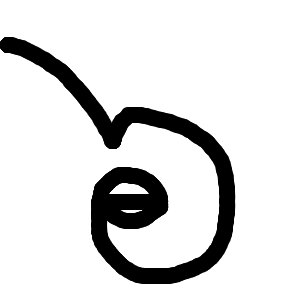

In [39]:
idx = 460
print(Path(paths[idx]).parent.name)
Image.open(paths[idx])

In [116]:
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import shutil

train_paths, test_paths = train_test_split(paths, test_size=0.1, random_state=42)

In [106]:
for i in range(10):
    os.makedirs(f"data/train/{i}", exist_ok=True)
    os.makedirs(f"data/validation/{i}", exist_ok=True)

In [114]:
def copy_to_destination(src_paths, dst_path: str = "data/train/"):
    for path in tqdm(src_paths):
        path = Path(path)
        if path.parent.name == "10":
            parent_dir = "0"
        else:
            parent_dir = path.parent.name
        shutil.copy(path, op.join(dst_path, parent_dir, path.name))

In [115]:
copy_to_destination(train_paths, "data/train/")
copy_to_destination(test_paths, "data/validation/")

In [118]:
len(glob("data/train/*/*")), len(glob("data/validation/*/*"))

(1611, 179)

## **Create a custom dataset and a dataloader**

In [119]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [120]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

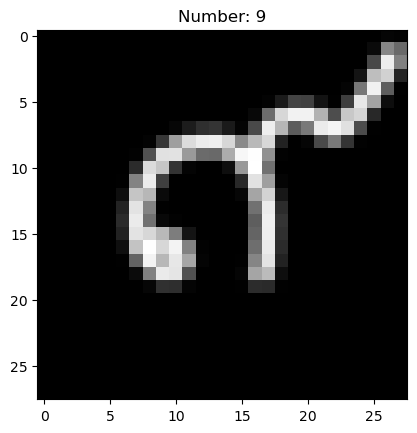

In [121]:
img = Image.open(paths[100])
img = (1 - transform(img)).squeeze(0)
plt.title("Number: {}".format(Path(paths[100]).parent.name))
plt.imshow(img, cmap="gray")
plt.show()

In [124]:
class ThaiDigitDataset(Dataset):
    def __init__(self, img_dir: str, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = [(p, Path(p).parent.name) for p in glob(op.join(img_dir, "*", "*"))]
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        image, label = self.img_labels[idx]
        label = int(label)
        image = Image.open(image)
        if self.transform:
            image = 1 - self.transform(image)
        return image, label

In [125]:
train_thaidigit_dataset = ThaiDigitDataset("data/train/", transform=transform)
val_thaidigit_dataset = ThaiDigitDataset("data/validation/", transform=transform)

In [145]:
train_loader = DataLoader(train_thaidigit_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_thaidigit_dataset, batch_size=16, shuffle=False)

In [127]:
# load example batch
images, labels = next(iter(train_loader))

In [128]:
images.shape, labels

(torch.Size([16, 1, 28, 28]),
 tensor([1, 2, 1, 4, 9, 1, 5, 3, 0, 0, 3, 8, 4, 3, 7, 0]))

## **Create the model**

In [152]:
import torch.nn as nn
import torch.nn.functional as F

class ThaiDigitNet(nn.Module):
    def __init__(self):
        super(ThaiDigitNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [153]:
net = ThaiDigitNet()
images, labels = next(iter(train_loader))
pred = net(images)

In [154]:
images.shape, pred.shape # check the size

(torch.Size([16, 1, 28, 28]), torch.Size([16, 10]))

## **Train the model**

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
update_steps = 50
n_epochs = 50

for epoch in range(n_epochs):
    # training
    net.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        pred = net(images)
        loss = loss_fn(pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % update_steps == 0:
            print(f"loss: {loss.item()} [epoch: {epoch} / # {batch_idx * len(images)}]")

    # validation
    net.eval()
    val_loss, correct = 0, 0
    n_val = len(val_loader.dataset)
    for images, labels in val_loader:
        pred = net(images)
        val_loss += loss_fn(pred, labels).item()
        correct += (pred.argmax(1) == labels).float().sum().item()
    print(f"validation accuracy = {correct / n_val}, average loss = {val_loss / len(val_loader)}")

## **Use the model**

In [160]:
img = Image.open("data/validation/5/0f14b574-daf6-4a22-ae06-86eaeee72efa.png")
img = transform(img)

In [161]:
img.shape

torch.Size([1, 28, 28])

In [163]:
pred = net(img).argmax(dim=1)

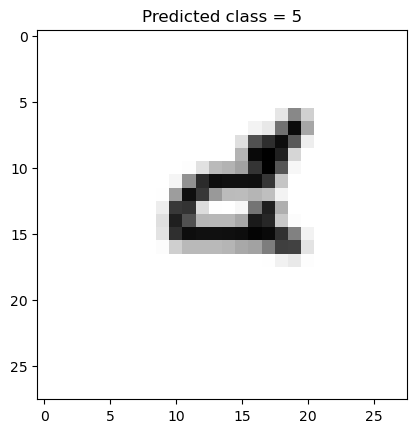

In [167]:
plt.title(f"Predicted class = {pred.numpy()[0]}")
plt.imshow(img.squeeze(0), cmap="gray")